In [16]:
import os
import re
import pandas as pd
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
gdal.UseExceptions()

In [12]:
BUCKET = '1182020'
COLLECTION = 'MODIS_land_cover'

In [29]:
# copy metadata from GCP to local
!gsutil -m -q cp -r gs://{BUCKET}/earth_engine/metadata/{COLLECTION} ./metadata

In [13]:
# copy images from GCP to local
!gsutil -m -q cp -r gs://{BUCKET}/earth_engine/images_tif/{COLLECTION} ./images_tif

In [31]:
p = re.compile('[A-Z]{3}')
countries = [country.replace('.csv', '') for country in os.listdir(F'./metadata/{COLLECTION}') if p.match(country)]
print(sorted(countries))

['ALB', 'AUT', 'BDI', 'BEL', 'BEN', 'BFA', 'BLZ', 'BRA', 'CAF', 'CIV', 'CMR', 'COD', 'COG', 'COL', 'CRI', 'DOM', 'ECU', 'ETH', 'GHA', 'GIN', 'GTM', 'HND', 'IND', 'IRL', 'ISR', 'JOR', 'KEN', 'LBR', 'MDG', 'MEX', 'MKD', 'MLI', 'MOZ', 'MWI', 'NER', 'NGA', 'NIC', 'PAN', 'PER', 'PRY', 'RWA', 'SDN', 'SEN', 'SLE', 'SLV', 'SWZ', 'TCD', 'TGO', 'TZA', 'UGA', 'URY', 'ZAF', 'ZWE']


In [14]:
country = 'ALB'
image_fns = os.listdir(F'./{COLLECTION}/{country}/')
image_fps = [F'./{COLLECTION}/{country}/{image_fn}' for image_fn in image_fns]

In [15]:
ds = gdal.Open(image_fps[0])
print(ds.GetProjection())
print(ds.GetGeoTransform())

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
(19.295812302887324, 0.008983152841195215, 0.0, 42.69692545420086, 0.0, -0.008983152841195215)


In [34]:
ds.GetRasterBand(1).Checksum()
array = ds.ReadAsArray()
array.shape

(13, 342, 192)

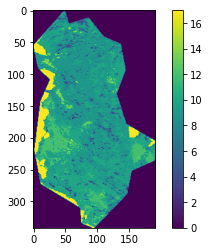

In [35]:
plt.imshow(array[0,:,:])
plt.colorbar()

In [59]:
# function to get counts of pixel values by band
def pixel_value_counts(img, country):
    # care about bands LC_Type1-5
    bands = range(5)
    fig, axs = plt.subplots(1, 5, figsize=(15, 5))
    fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.05)
    for band, ax in zip(bands, axs):
        im = ax.imshow(img[band,:,:])
        ax.axis('off')
        ax.set_title(F"{country}: Band LC_Type{band+1}")
        fig.colorbar(im, ax=ax)
        
#     for band in bands:
#         plt
#         plt.colorbar()

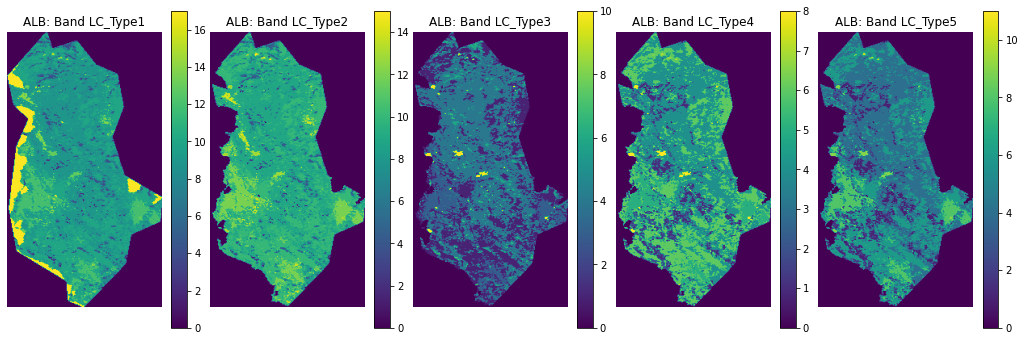

In [60]:
pixel_value_counts(array, country)